In [114]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import math

In [115]:
# my helpers!
from shared import (
    dataset_local_path,
    bootstrap_auc,
    simple_boxplot,
)

# stdlib:
from dataclasses import dataclass, field
import json, gzip
from typing import Dict, List

In [116]:
#%% load up the data
# Try 'POETRY'
dataset = "POETRY"
examples: List[str] = []
ys: List[bool] = []

if dataset == "WIKI":
    with gzip.open(dataset_local_path("lit-wiki-2020.jsonl.gz"), "rt") as fp:
        for line in fp:
            info = json.loads(line)
            # Note: the data contains a whole bunch of extra stuff; we just want numeric features for now.
            keep = info["body"]
            # whether or not it's poetry is our label.
            ys.append(info["truth_value"])
            # hold onto this single dictionary.
            examples.append(keep)
else:
    # take only one per book!
    by_book = {}
    with open(dataset_local_path("poetry_id.jsonl")) as fp:
        for line in fp:
            info = json.loads(line)
            # dictionary keeps this key unique:
            by_book[info["book"]] = info
    # now extract only one page per book here:
    for info in by_book.values():
        # Note: the data contains a whole bunch of extra stuff; we just want numeric features for now.
        keep = info["words"]
        # whether or not it's poetry is our label.
        ys.append(info["poetry"])
        # hold onto this single dictionary.
        examples.append(keep)

In [117]:
#%% Split data:

RANDOM_SEED = 1234

## split off train/validate (tv) pieces.
ex_tv, ex_test, y_tv, y_test = train_test_split(
    examples,
    ys,
    train_size=0.75,
    shuffle=True,
    random_state=RANDOM_SEED,
)
# split off train, validate from (tv) pieces.
ex_train, ex_vali, y_train, y_vali = train_test_split(
    ex_tv, y_tv, train_size=0.66, shuffle=True, random_state=RANDOM_SEED
)

In [118]:
#%% Analyze Text

from sklearn.feature_extraction.text import CountVectorizer


# Note we're doing "CountVectorizer" here and not TfidfVectorizer. Hmm...
word_features = CountVectorizer(
    strip_accents="unicode",
    lowercase=True,
    ngram_range=(1, 2),
)

#The lower and upper boundary of the range of n-values for 
#different word n-grams or char n-grams to be extracted. 
#All values of n such such that min_n <= n <= max_n will be used. 
#For example an ngram_range of (1, 1) means only unigrams, 
#(1, 2) means unigrams and bigrams, and (2, 2) means only bigrams. Only applies if analyzer is not callable.

# How does it take a whole paragraph and turn it into words?
text_to_words = word_features.build_analyzer()
# text_to_words is a function (str) -> List[str]
# assert text_to_words("Hello world!") == ["hello", "world"]

# Learn columns from training data (again)
word_features.fit(ex_train)
# Translate our list of texts -> matrices of counts
X_train = word_features.transform(ex_train)
X_vali = word_features.transform(ex_vali)
X_test = word_features.transform(ex_test)

print(X_train.shape, X_vali.shape, X_test.shape)

(680, 156207) (351, 156207) (344, 156207)


In [119]:
#%% Accumulate results here; to be box-plotted.
results: Dict[str, List[float]] = {}

In [120]:
#%% try sklearn MultinomialNB:

## SKLearn has it's own Multinomial Naive Bayes,
#  and it uses the alpha / additive smoothing to deal with zeros!
from sklearn.naive_bayes import MultinomialNB

# Try a couple alpha values (what to do with zero-prob words!)
# Alpha can really be anything positive!
for alpha in [0.1,1,10,100,1000]:
    m = MultinomialNB(alpha=alpha)
    m.fit(X_train, y_train)
    scores = m.predict_proba(X_vali)[:, 1]
    print("Alpha - ", alpha)
    print(
        "Accuracy: {:.3}, AUC: {:.3}".format(
            m.score(X_vali, y_vali), roc_auc_score(y_score=scores, y_true=y_vali)
        )
    )
    print("What I called log(beta)={}".format(m.class_log_prior_[1]))
    results["MNB(alpha={})".format(alpha)] = bootstrap_auc(m, X_vali, y_vali)

Alpha -  0.1
Accuracy: 0.906, AUC: 0.933
What I called log(beta)=-1.4851401957565225
Alpha -  1
Accuracy: 0.855, AUC: 0.869
What I called log(beta)=-1.4851401957565225
Alpha -  10
Accuracy: 0.769, AUC: 0.677
What I called log(beta)=-1.4851401957565225
Alpha -  100
Accuracy: 0.769, AUC: 0.608
What I called log(beta)=-1.4851401957565225
Alpha -  1000
Accuracy: 0.769, AUC: 0.576
What I called log(beta)=-1.4851401957565225


In [121]:
#%% Showcase linar smoothing:

from collections import Counter
import typing


@dataclass
class CountLanguageModel:
    """ The number of times each word has been observed. """

    counts: typing.Counter[str] = field(default_factory=Counter)
    """ The total number of observed words (any word)"""
    total: int = 0
    # Don't need an alpha

    def add_example(self, words: List[str]) -> None:
        for word in words:
            self.counts[word] += 1
        self.total += len(words)

    def prob(self, word: str) -> float:
        return self.counts[word] / self.total


# Make one of these for the positive class:
is_positive = CountLanguageModel()
# Make one of these for ALL documents.
is_random = CountLanguageModel()

# Train these two model pieces:
for y, ex in zip(y_train, ex_train):
    words = text_to_words(ex)
    # with linear smoothing, everything goes in random (positive OR negative)
    is_random.add_example(words)
    # but only positive go in positive:
    if y:
        is_positive.add_example(words)

print("positive-size: {}".format(is_positive.total))
print("rand-size: {}".format(is_random.total))

positive-size: 84984
rand-size: 393281


In [122]:
def score_words(
    words: List[str],
    linear: float,
    positive: CountLanguageModel,
    background: CountLanguageModel,
) -> float:
    score = 0.0
    # Compute log-product of word-probabilities:
    for word in words:
        # prob-yes!
        prob_positive = positive.prob(word)
        # prob-no!
        prob_negative = background.prob(word)
        # words that are only in vali/test:
        if prob_positive == 0.0 and prob_negative == 0.0:
            continue

        # mix the positive and negative together (to avoid prob_positive being a zero)
        smoothed_positive = (prob_positive * linear) + (prob_negative * (1 - linear))
        # multiply up P(yes) / P(no) but logged!
        score += math.log(smoothed_positive) - math.log(prob_negative)
    return score


#
# The linear parameter is traditionally a non-zero, non-one probability:
#     (0 < linear < 1)
for linear in [0.01, 0.5, 0.99]:
    scores = []
    for ex in ex_vali:
        score = score_words(text_to_words(ex), linear, is_positive, is_random)
        scores.append(score)

    # Note that there's no accuracy because I haven't figured out beta...
    print(
        "Linear[{}] AUC={:.3}".format(
            linear, roc_auc_score(y_score=scores, y_true=y_vali)
        )
    )
    # bootstrap AUC: (doing this manually because the helper function doesn't accept scores out of nowhere!)
    dist = []
    # do the bootstrap:
    for trial in range(100):
        sample_pred, sample_truth = resample(
            scores, y_vali, random_state=trial + RANDOM_SEED
        )  # type:ignore
        score = roc_auc_score(y_true=sample_truth, y_score=sample_pred)  # type:ignore
        dist.append(score)
    results["Linear[{}]".format(linear)] = dist

Linear[0.01] AUC=0.947
Linear[0.5] AUC=0.943
Linear[0.99] AUC=0.852


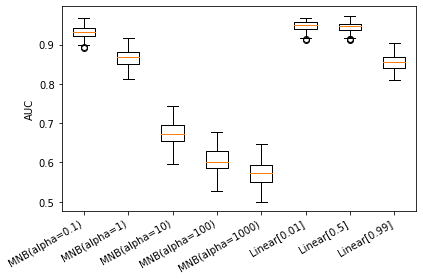

<module 'matplotlib.pyplot' from '/Users/Alderik/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [123]:
#%% Boxplot all AUC results:
simple_boxplot(results, ylabel="AUC", save="{}-text-AUC.png".format(dataset))

### 1. Explore alpha and linear parameters; make a decision about what a good choice for this dataset might be.

Alpha of .1 and linear parameter of 0.01 were the best from my test

# 2 is once again a choose-your-own:

### 2A. Explore ngrams, lowercase v. uppercase, etc. (how changing CountVectorizer changes performance, or not)

Unigrams & Bigrams improved performance (1,2) compared to only Unigrams (1,1)   
Only bigrams (2,2) decreased performance compared only unigrams (1,1) and (1,2)

### 2B. Explore the difference between today's approaches to the WIKI dataset and yesterday's.

p05 used TFIDFVectorizer instead of p06 using CountVectorizer   
p05 used many different linear models and tree models, p06 we use a Multinomial Naive Bayes

### 2C. Explore the differences between the WIKI dataset and the POETRY dataset.

With the optimized alpha and linear parameter, the poetry dataset gets a much higher AUC and accuracy